In [120]:
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.inspection import permutation_importance
import shap
import matplotlib.pyplot as plt
import xgboost as xgb
import os
from sklearn.inspection import permutation_importance
from collections import Counter
import pickle


df = pd.read_csv("/Users/erningxu/Desktop/data assignment/Final_Report/data/data_after_EDA.csv")
df = df.sort_values(by='date')
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day_of_month'] = df['date'].dt.day
df['week_of_year'] = df['date'].dt.isocalendar().week
df['is_weekend'] = df['date'].dt.dayofweek.isin([5, 6]).astype(int)

In [121]:
X = df.drop(columns=['actual_productivity'])
y = df['actual_productivity']

tscv = TimeSeriesSplit(n_splits=3)
splits = list(tscv.split(X, y))

train_index = splits[0][0]
val_index = splits[1][1]
test_index = splits[2][1]

X_train = X.iloc[train_index]
y_train = y.iloc[train_index]
X_val = X.iloc[val_index]
y_val = y.iloc[val_index]
X_test = X.iloc[test_index]
y_test = y.iloc[test_index]

train_date_range = (df.iloc[train_index]['date'].min(), df.iloc[train_index]['date'].max())
val_date_range = (df.iloc[val_index]['date'].min(), df.iloc[val_index]['date'].max())
test_date_range = (df.iloc[test_index]['date'].min(), df.iloc[test_index]['date'].max())

print("Training set date range:", train_date_range)
print("Validation set date range:", val_date_range)
print("Test set date range:", test_date_range)



Training set date range: (Timestamp('2015-01-01 00:00:00'), Timestamp('2015-01-18 00:00:00'))
Validation set date range: (Timestamp('2015-02-04 00:00:00'), Timestamp('2015-02-23 00:00:00'))
Test set date range: (Timestamp('2015-02-23 00:00:00'), Timestamp('2015-03-11 00:00:00'))


In [122]:
onehot_ftrs = ['department', 'team']
ordinal_ftrs = ['day', 'quarter']
std_ftrs = ['targeted_productivity', 'smv', 'over_time', 'incentive',
            'idle_time', 'idle_men', 'no_of_style_change', 'no_of_workers',
            'day_of_month', 'week_of_year', 'year', 'month', 'is_weekend']

ordinal_encoder = OrdinalEncoder(categories=[
    ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
    ['Quarter1', 'Quarter2', 'Quarter3', 'Quarter4']
])

X_train = X_train.drop(columns=['date'], errors='ignore')
X_val = X_val.drop(columns=['date'], errors='ignore')
X_test = X_test.drop(columns=['date'], errors='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(sparse_output=False), onehot_ftrs),
        ('ordinal', ordinal_encoder, ordinal_ftrs),
        ('std', StandardScaler(), std_ftrs)
    ],
    remainder='passthrough'
)

clf = Pipeline(steps=[('preprocessor', preprocessor)])
X_train_prep = clf.fit_transform(X_train)
X_val_prep = clf.transform(X_val)
X_test_prep = clf.transform(X_test)

def get_feature_names_from_column_transformer(preprocessor, original_feature_names):
    feature_names = []
    for name, transformer, cols in preprocessor.transformers_:
        if name == "remainder" and transformer == "passthrough":
            feature_names.extend(cols)
        elif hasattr(transformer, 'get_feature_names_out'):
            transformed_names = transformer.get_feature_names_out()
            feature_names.extend(transformed_names)
        else:
            feature_names.extend(cols)
    return feature_names

original_feature_names = X_train.columns.tolist()
feature_names = get_feature_names_from_column_transformer(clf.named_steps["preprocessor"], original_feature_names)

print("Feature names:", feature_names)
print("Original training shape:", X_train.shape)
print("Transformed training shape:", X_train_prep.shape)
print("Sample transformed training data:\n", X_train_prep[:5])


Feature names: ['department_finishing', 'department_sewing', 'team_1', 'team_2', 'team_3', 'team_4', 'team_5', 'team_6', 'team_7', 'team_8', 'team_9', 'team_10', 'team_11', 'team_12', 'day', 'quarter', 'targeted_productivity', 'smv', 'over_time', 'incentive', 'idle_time', 'idle_men', 'no_of_style_change', 'no_of_workers', 'day_of_month', 'week_of_year', 'year', 'month', 'is_weekend', 'wip']
Original training shape: (300, 18)
Transformed training shape: (300, 30)
Sample transformed training data:
 [[ 0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  3.00000000e+00  0.00000000e+00
   4.71081530e-01  1.01503979e+00  3.72101312e-01  2.57881198e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  1.11789555e+00
  -1.73994490e+00 -1.57461534e+00  0.00000000e+00  0.00000000e+00
  -7.55434066e-01  1.10800000e+03]
 

In [123]:
def pattern_based_missing_value_modeling(X_train, y_train, X_val, y_val, X_test, y_test, models_template, param_grids, random_states, preprocessor):
    mask = X_test.isnull()
    unique_rows = np.unique(mask, axis=0)
    print(f"There are {len(unique_rows)} unique missing value patterns.")
    mae_results = {model_name: {state: [] for state in random_states} for model_name in models_template.keys()}
    mse_results = {model_name: {state: [] for state in random_states} for model_name in models_template.keys()}
    best_params_per_model = {model_name: {state: None for state in random_states} for model_name in models_template.keys()}
    for pattern_idx, row_mask in enumerate(unique_rows):
        print(f"\nHandling pattern {pattern_idx + 1}/{len(unique_rows)}...")
        test_subset = X_test.loc[(mask == row_mask).all(axis=1)]
        test_y_subset = y_test.loc[test_subset.index]
        valid_features = X_test.columns[~row_mask]
        sub_X_train = X_train[valid_features].dropna()
        sub_y_train = y_train.loc[sub_X_train.index]
        sub_X_val = X_val[valid_features].dropna()
        sub_y_val = y_val.loc[sub_X_val.index]
        sub_X_test = test_subset[valid_features]
        clf = Pipeline(steps=[('preprocessor', preprocessor)])
        sub_X_train_prep = clf.fit_transform(sub_X_train)
        sub_X_val_prep = clf.transform(sub_X_val)
        sub_X_test_prep = clf.transform(sub_X_test)
        for random_state in random_states:
            print(f"\nTraining models for random_state={random_state}...")
            for model_name, model in models_template.items():
                print(f"Tuning {model_name} for pattern {pattern_idx + 1}...")
                if model_name == "Random Forest":
                    model = RandomForestRegressor(random_state=random_state)
                grid_search = GridSearchCV(model, param_grids[model_name], cv=3, scoring='neg_mean_absolute_error')
                grid_search.fit(sub_X_train_prep, sub_y_train)
                test_predictions = grid_search.best_estimator_.predict(sub_X_test_prep)
                mae = mean_absolute_error(test_y_subset, test_predictions)
                mse = mean_squared_error(test_y_subset, test_predictions)
                mae_results[model_name][random_state].append(mae)
                mse_results[model_name][random_state].append(mse)
                best_params_per_model[model_name][random_state] = grid_search.best_params_

    aggregated_mae = {model_name: {state: np.mean(mae_results[model_name][state]) for state in random_states} for model_name in models_template.keys()}
    aggregated_mse = {model_name: {state: np.mean(mse_results[model_name][state]) for state in random_states} for model_name in models_template.keys()}

    best_overall_params = {}
    for model_name in models_template.keys():
        best_state = min(aggregated_mae[model_name], key=aggregated_mae[model_name].get)
        best_overall_params[model_name] = best_params_per_model[model_name][best_state]

    return aggregated_mae, aggregated_mse, best_overall_params




In [124]:
output_directory = "/Users/erningxu/Desktop/data assignment/Final_Report/data"
if not os.path.exists(output_directory):
    os.makedirs(output_directory)  
os.chdir(output_directory)
df.to_csv("data_after_pre.csv", index=False)
print(f"File saved to {os.path.join(output_directory, 'data_after_pre.csv')}")

File saved to /Users/erningxu/Desktop/data assignment/Final_Report/data/data_after_pre.csv


In [125]:
models_template = {
    "Ridge Regression": Ridge(),
    "Lasso Regression": Lasso(),
    "Random Forest": RandomForestRegressor(),
    "K-Nearest Neighbors": KNeighborsRegressor(),
    "Support Vector Regression": SVR()
}

param_grids = {
    "Ridge Regression": {"alpha": [0.1, 1, 10, 100]},
    "Lasso Regression": {"alpha": [0.01, 0.1, 1, 10]},
    "Random Forest": {
        "n_estimators": [50, 100, 200],
        "max_depth": [None, 10, 20],
        "min_samples_split": [2, 5, 10]
    },
    "K-Nearest Neighbors": {
        "n_neighbors": [3, 5, 7, 10],
        "weights": ["uniform", "distance"]
    },
    "Support Vector Regression": {
        "C": [0.1, 1, 10],
        "kernel": ["linear", "rbf"],
        "gamma": [0.01, 0.1, 1]
    }
}

random_states = [0, 27, 42, 100]

aggregated_mae, aggregated_mse, best_overall_params = pattern_based_missing_value_modeling(
    X_train, y_train, X_val, y_val, X_test, y_test,
    models_template=models_template,
    param_grids=param_grids,
    random_states=random_states,
    preprocessor=preprocessor
)

print("\nMean Absolute Error (MAE):")
for model_name, states in aggregated_mae.items():
    print(f"{model_name}:")
    for state, mae in states.items():
        print(f"  Random State {state}: MAE: {mae:.4f}")

print("\nMean Squared Error (MSE):")
for model_name, states in aggregated_mse.items():
    print(f"{model_name}:")
    for state, mse in states.items():
        print(f"  Random State {state}: MSE: {mse:.4f}")

print("\nBest Parameters:")
for model_name, params in best_overall_params.items():
    print(f"{model_name}: Best Parameters: {params}")




There are 2 unique missing value patterns.

Handling pattern 1/2...

Training models for random_state=0...
Tuning Ridge Regression for pattern 1...
Tuning Lasso Regression for pattern 1...
Tuning Random Forest for pattern 1...
Tuning K-Nearest Neighbors for pattern 1...
Tuning Support Vector Regression for pattern 1...

Training models for random_state=27...
Tuning Ridge Regression for pattern 1...
Tuning Lasso Regression for pattern 1...
Tuning Random Forest for pattern 1...
Tuning K-Nearest Neighbors for pattern 1...
Tuning Support Vector Regression for pattern 1...

Training models for random_state=42...
Tuning Ridge Regression for pattern 1...
Tuning Lasso Regression for pattern 1...
Tuning Random Forest for pattern 1...
Tuning K-Nearest Neighbors for pattern 1...
Tuning Support Vector Regression for pattern 1...

Training models for random_state=100...
Tuning Ridge Regression for pattern 1...
Tuning Lasso Regression for pattern 1...
Tuning Random Forest for pattern 1...
Tuning K-N


Baseline Metrics (Mean and Standard Deviation):
      Validation MAE  Validation MSE  Test MAE  Test MSE
mean        0.149251        0.038622  0.120316  0.028788
std         0.000000        0.000000  0.000000  0.000000

Model Metrics (Mean and Standard Deviation):
                           MAE Mean   MAE Std  MSE Mean   MSE Std
Ridge Regression           0.266801  0.000000  0.967681  0.000000
Lasso Regression           0.162905  0.000000  0.169143  0.000000
Random Forest              0.119261  0.001873  0.029357  0.000724
K-Nearest Neighbors        0.139149  0.000000  0.034680  0.000000
Support Vector Regression  0.318766  0.000000  1.530939  0.000000
Baseline                   0.120316  0.000000  0.028788  0.000000


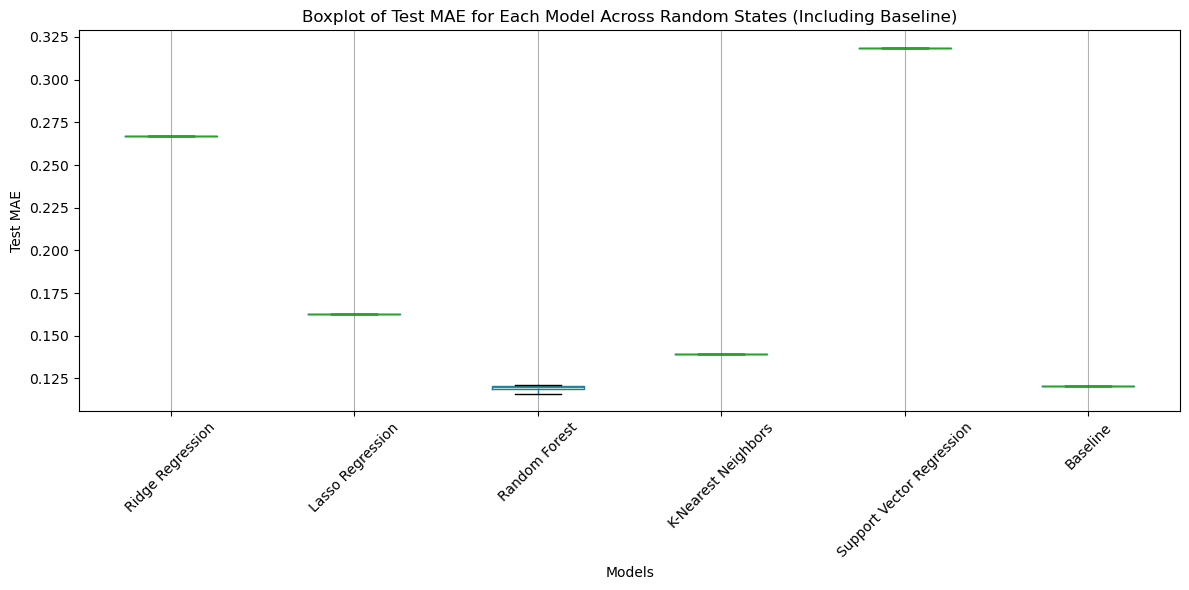

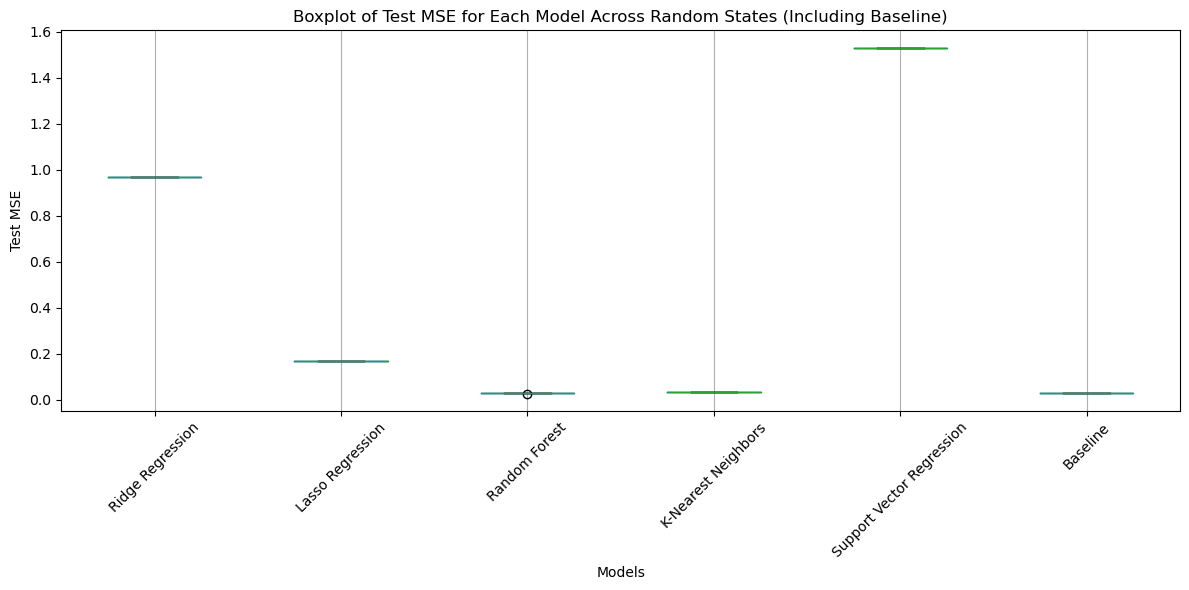

In [126]:
# Initialize lists for baseline metrics
baseline_val_mae_list = []
baseline_val_mse_list = []
baseline_test_mae_list = []
baseline_test_mse_list = []

# Compute baseline metrics for each random state
for random_state in random_states:
    baseline_prediction = np.mean(y_train)  
    baseline_val_predictions = np.full_like(y_val, baseline_prediction) 
    baseline_test_predictions = np.full_like(y_test, baseline_prediction)  
    baseline_val_mae = mean_absolute_error(y_val, baseline_val_predictions)
    baseline_val_mse = mean_squared_error(y_val, baseline_val_predictions)
    baseline_test_mae = mean_absolute_error(y_test, baseline_test_predictions)
    baseline_test_mse = mean_squared_error(y_test, baseline_test_predictions)
    baseline_val_mae_list.append(baseline_val_mae)
    baseline_val_mse_list.append(baseline_val_mse)
    baseline_test_mae_list.append(baseline_test_mae)
    baseline_test_mse_list.append(baseline_test_mse)

# Create DataFrame for baseline metrics
baseline_metrics_df = pd.DataFrame({
    "Validation MAE": baseline_val_mae_list,
    "Validation MSE": baseline_val_mse_list,
    "Test MAE": baseline_test_mae_list,
    "Test MSE": baseline_test_mse_list
})

# Calculate mean and standard deviation for baseline metrics
baseline_mean_std = baseline_metrics_df.describe().loc[['mean', 'std']]

print("\nBaseline Metrics (Mean and Standard Deviation):")
print(baseline_mean_std)

# Calculate metrics for each model
model_metrics = {
    model_name: {
        "Test MAE": [aggregated_mae[model_name][state] for state in random_states],
        "Test MSE": [aggregated_mse[model_name][state] for state in random_states],
    }
    for model_name in aggregated_mae.keys()  
}

# Combine baseline and model metrics
combined_metrics = {
    **model_metrics,
    "Baseline": {
        "Test MAE": baseline_test_mae_list,
        "Test MSE": baseline_test_mse_list,
    },
}

# Calculate mean and standard deviation for each model's metrics
mean_std_metrics = {
    model: {
        "MAE Mean": np.mean(metrics["Test MAE"]),
        "MAE Std": np.std(metrics["Test MAE"]),
        "MSE Mean": np.mean(metrics["Test MSE"]),
        "MSE Std": np.std(metrics["Test MSE"]),
    }
    for model, metrics in combined_metrics.items()
}

# Convert mean/std metrics to DataFrame
mean_std_df = pd.DataFrame(mean_std_metrics).T

print("\nModel Metrics (Mean and Standard Deviation):")
print(mean_std_df)

# Prepare DataFrames for plotting
mae_df = pd.DataFrame({model: metrics["Test MAE"] for model, metrics in combined_metrics.items()})
mse_df = pd.DataFrame({model: metrics["Test MSE"] for model, metrics in combined_metrics.items()})

# Plot boxplot for MAE
plt.figure(figsize=(12, 6))
mae_df.boxplot()
plt.title("Boxplot of Test MAE for Each Model Across Random States (Including Baseline)")
plt.ylabel("Test MAE")
plt.xlabel("Models")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Plot boxplot for MSE
plt.figure(figsize=(12, 6))
mse_df.boxplot()
plt.title("Boxplot of Test MSE for Each Model Across Random States (Including Baseline)")
plt.ylabel("Test MSE")
plt.xlabel("Models")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()



Random Forest Test MSE: 0.0285
Random Forest Test MAE: 0.1174


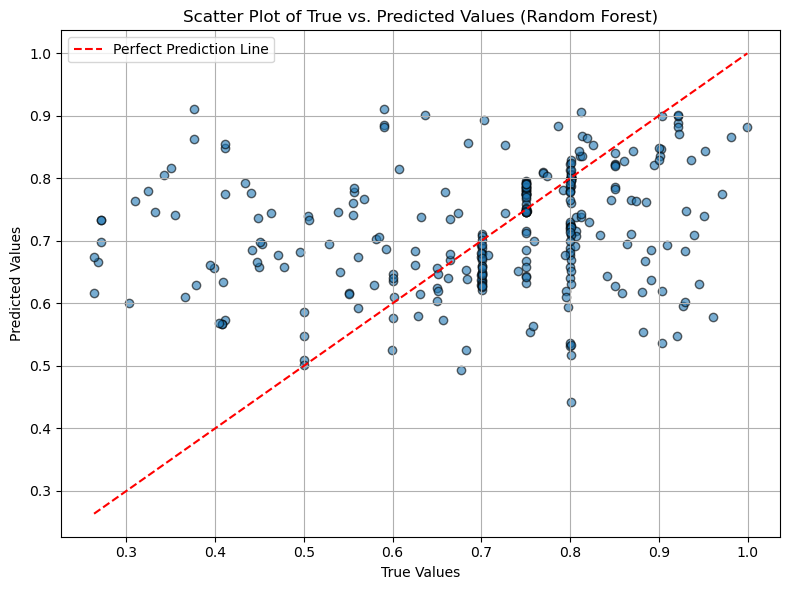

In [127]:
random_forest_model = RandomForestRegressor(
    max_depth=20,
    min_samples_split=2,
    n_estimators=100,
    random_state=0  
)

random_forest_model.fit(X_train_prep, y_train)
test_predictions = random_forest_model.predict(X_test_prep)
mse = mean_squared_error(y_test, test_predictions)
mae = mean_absolute_error(y_test, test_predictions)
print(f"\nRandom Forest Test MSE: {mse:.4f}")
print(f"Random Forest Test MAE: {mae:.4f}")

plt.figure(figsize=(8, 6))
plt.scatter(y_test, test_predictions, alpha=0.6, edgecolor='k')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', label="Perfect Prediction Line")
plt.title("Scatter Plot of True vs. Predicted Values (Random Forest)")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()






Plotting Permutation Importance...


/var/folders/hy/_mp71xls21bglz10144kprvh0000gn/T/ipykernel_88338/113949115.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


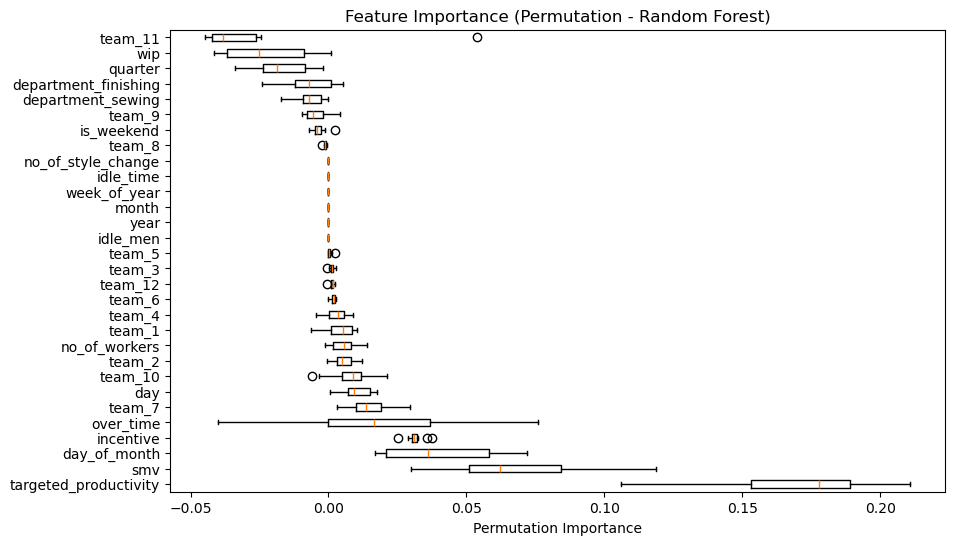


Performing SHAP Analysis...


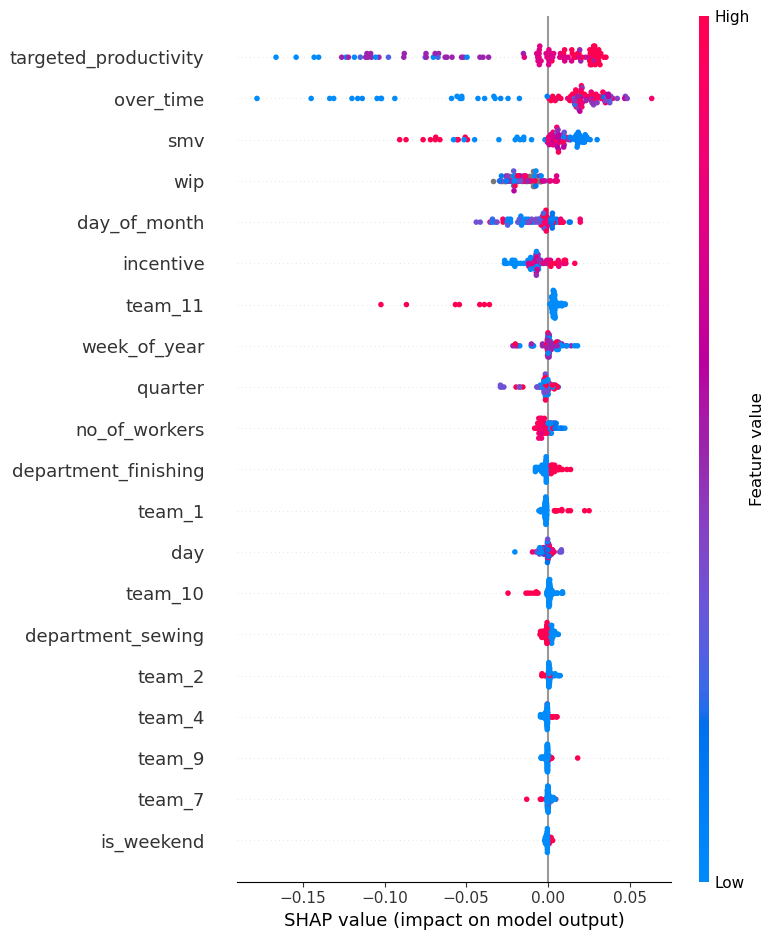

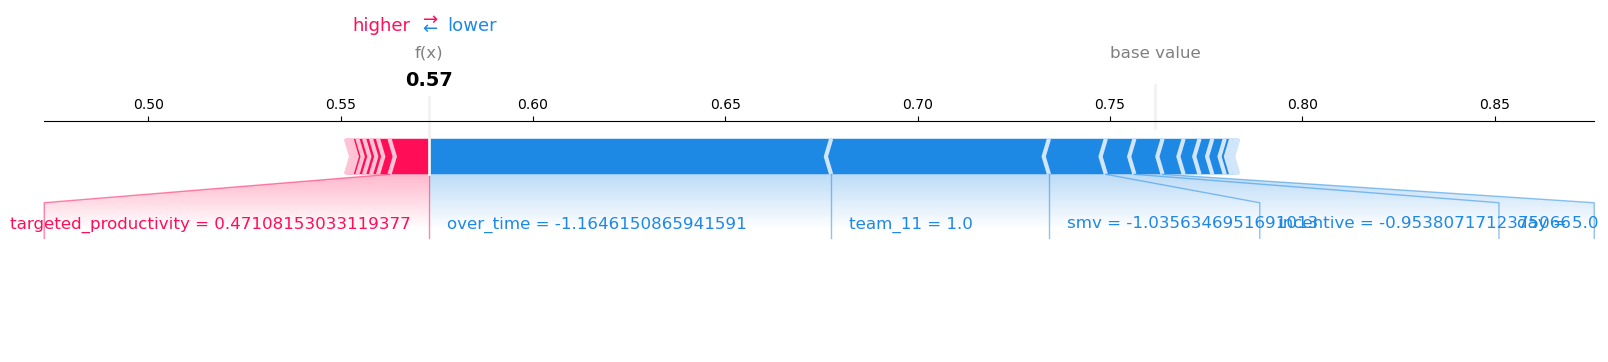

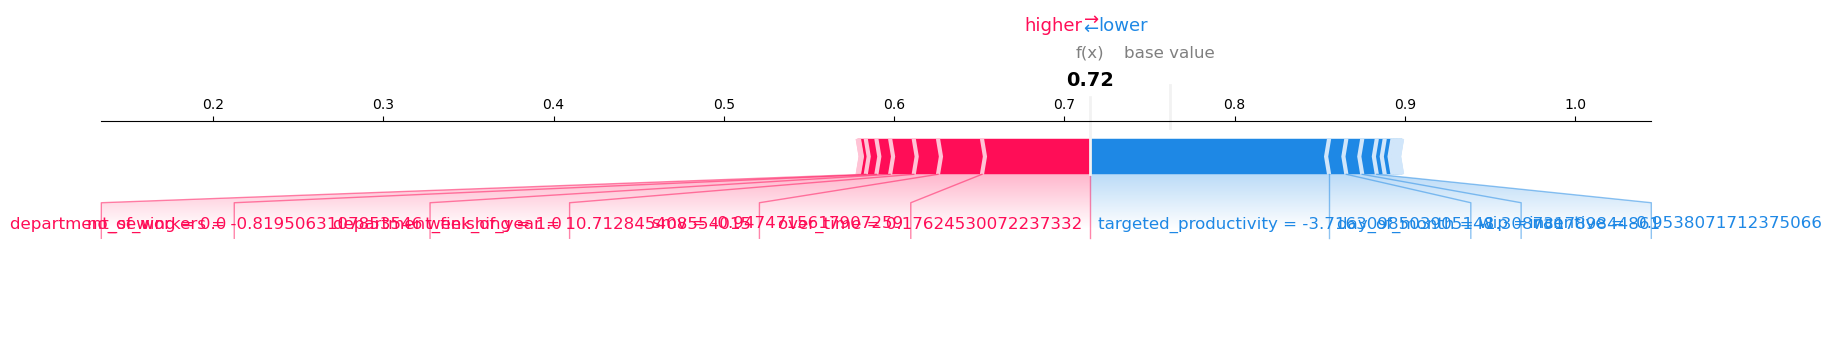


Fitting XGBoost Model...


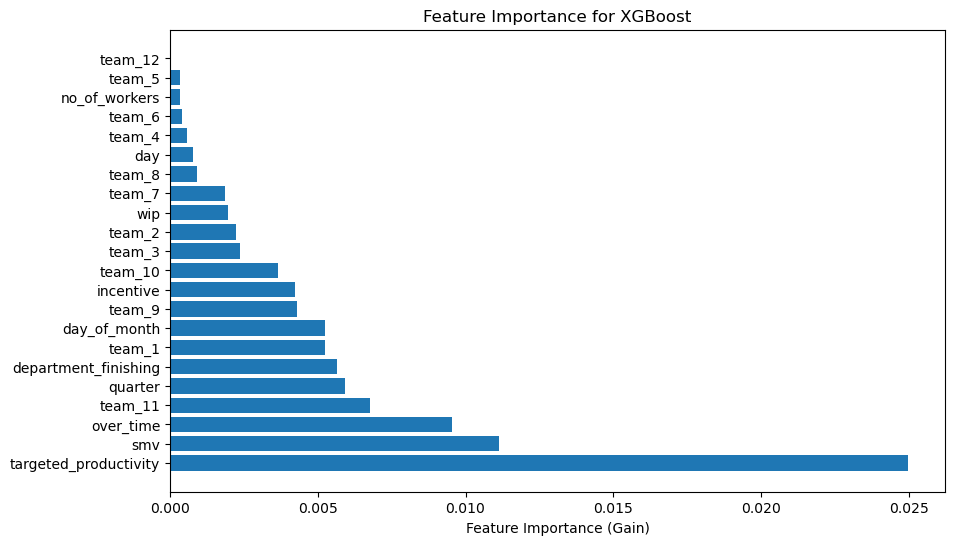

In [128]:
def plot_permutation_importance_rf(model, X_val, y_val, feature_names):
    result = permutation_importance(model, X_val, y_val, n_repeats=10, random_state=42)
    sorted_idx = result.importances_mean.argsort()[::-1]

    plt.figure(figsize=(10, 6))
    plt.boxplot(
        result.importances[sorted_idx].T,  
        vert=False,
        labels=np.array(feature_names)[sorted_idx]
    )
    plt.xlabel("Permutation Importance")
    plt.title("Feature Importance (Permutation - Random Forest)")
    plt.show()

def shap_analysis_rf(model, X_sample, feature_names):
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_sample)
    shap.summary_plot(shap_values, X_sample, feature_names=feature_names)
    shap.initjs()  
    shap.force_plot(
        explainer.expected_value,
        shap_values[37],
        X_sample.iloc[37],
        feature_names=feature_names,
        matplotlib=True,
    )
    shap.initjs()  
    shap.force_plot(
        explainer.expected_value,
        shap_values[44],
        X_sample.iloc[44],
        feature_names=feature_names,
        matplotlib=True,
    )

def plot_xgboost_importance(model, feature_names):
    xgb_importances = model.get_booster().get_score(importance_type='gain')
    sorted_importances = sorted(
        {feature_names[int(k.split('f')[1])]: v for k, v in xgb_importances.items()}.items(),
        key=lambda x: x[1], reverse=True
    )
    
    plt.figure(figsize=(10, 6))
    plt.barh([item[0] for item in sorted_importances], [item[1] for item in sorted_importances])
    plt.xlabel("Feature Importance (Gain)")
    plt.title("Feature Importance for XGBoost")
    plt.show()

feature_names_rf = feature_names  

print("\nPlotting Permutation Importance...")
plot_permutation_importance_rf(random_forest_model, X_test_prep, y_test, feature_names_rf)

print("\nPerforming SHAP Analysis...")
X_sample_rf = pd.DataFrame(X_test_prep, columns=feature_names_rf).sample(100, random_state=42)
shap_analysis_rf(random_forest_model, X_sample_rf, feature_names_rf)

print("\nFitting XGBoost Model...")
xgb_model = xgb.XGBRegressor(n_estimators=100, random_state=42)
xgb_model.fit(X_train_prep, y_train)
plot_xgboost_importance(xgb_model, feature_names_rf)





In [129]:
results_dir = "/Users/erningxu/Desktop/data assignment/Final_Report/results"
os.makedirs(results_dir, exist_ok=True)
predictions_file_path = os.path.join(results_dir, "test_predictions.pkl")

with open(predictions_file_path, "wb") as f:
    pickle.dump(test_predictions, f)

print(f"Test predictions saved to {predictions_file_path}")

Test predictions saved to /Users/erningxu/Desktop/data assignment/Final_Report/results/test_predictions.pkl
